## What is Logistic Regression

### Classification Problem

As we know there are two types of supervised learning models: those that are used to **predict** a numerical variable and those that are used for **classification**. Up to now we have considered the problem of predicting a numerical variable, we now move on to the classification problem. In particular we focus on the so called Binomial Logistic Regression, where the response variable has two values 0 and 1 or pass and fail or true and false. Multinomial Logistic Regression deals with situations where the response variable can have three or more possible values. 

### Why Logistic, not Linear?

With binary classification, let $x$ be some feature and $y$ be the output which can be either 0 or 1.
The probability that the output is 1 given its input can be represented as:

$$P(y=1 \vert x) $$

If we predict the probability via linear regression, we can state it as:

$$P(y=1 \vert x) = \beta_0 + \beta_1 X$$

Linear regression model can generate the predicted probability as any number ranging from negative to positive infinity, whereas probability of an outcome can only lie between 0< P(x)<1.

To avoid this problem, log-odds function or logit function is used.

### Logit Function

Logistic regression can be expressed as:

\begin{equation}
\log \left( \frac{p(y=1\vert x)}{1-p(y=1\vert x)}\right) = \beta_0 + \beta_1 X
\end{equation}

where, the left hand side is called the *logit* or *log-odds* function, and $p/(1-p)$ is called *odds*. The odds signifies the ratio of probability of success to probability of failure. Therefore, in Logistic Regression, linear combination of inputs are mapped to the log(odds) - the output being equal to 1. If we take an inverse of the above function, we get:

\begin{equation}
Q=p(y=1 \vert x) = \frac{e^{\beta_0 + \beta_1 X}}{1+e^{\beta_0 + \beta_1 X}} = \frac{1}{1+e^{-(\beta_0 + \beta_1 X)}} =
\frac{1}{1+e^{-Y}}
\end{equation}

where $Y= \beta_0 + \beta_1 X$. 

This is known as the **Sigmoid Function** and it gives an S-shaped curve. It always gives a value of probability ranging from $0<p<1$. Now, let's simply plot the sigmoid function for some values in the range –7 to 7 to
see how it looks:

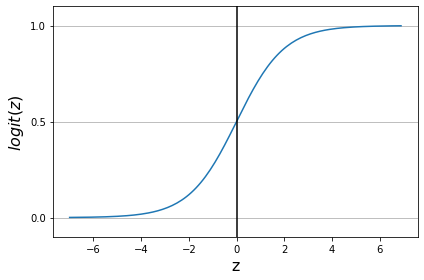

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return np.exp(z) / (1.0 + np.exp(z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z', fontsize = 16)
plt.ylabel('$ logit(z)$', fontsize = 16)
# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

### Estimation of Regression Coefficients

Unlike linear regression model, that uses Ordinary Least Square for parameter estimation, we use Maximum Likelihood Estimation.
There can be infinite sets of regression coefficients. The maximum likelihood estimate is that set of regression coefficients for which the probability of getting the data we have observed is maximum. In this case we can write simply:

\begin{equation}
{\cal{L}} = \prod\limits_{i=1}^n  Q(\mathbf{\beta}^T \mathbf{x})^{y(i)} \left[ 1 - Q(\mathbf{\beta}^T \mathbf{x})\right]^{1-y(i)} \Rightarrow \log{\cal{L}} = 
\sum\limits_{i=1}^n
\left\{
{y(i)} \cdot \ln Q(\mathbf{\beta}^T \mathbf{x}) 
+ (1-y(i)) \cdot \ln \left[ 1 - Q(\mathbf{\beta}^T \mathbf{x})\right] 
\right\}
\end{equation}

Now since in the binomial case $y_i = 1 \,or\, 0$, we can write

\begin{equation}L=\sum\limits_\text{POS OUT} \, \ln(Q) + \sum\limits_\text{NEG OUT} \, \ln(1-Q) \end{equation}

The first summation is over all the observations which led to positive outcomes and the second summation is over all observations which let to negative outcomes. This function cannot be maximized analytically and gradient ascent (analogous to gradient descent) methods must be used.

Let's write a short code snippet to create a plot that illustrates the cost of classifying
a single training example for different values of $\phi(z)$ :

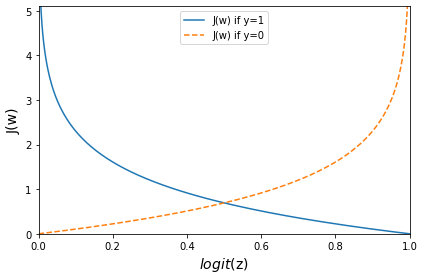

In [2]:
def cost_1(z):
    return - np.log(sigmoid(z))

def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$logit$(z)', fontsize=14)
plt.ylabel('J(w)', fontsize=14)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We can see that the cost approaches 0 (continuous line) if we correctly predict that
an example belongs to class 1. Similarly, we can see on the y-axis that the cost also
approaches 0 if we correctly predict y = 0 (dashed line). However, if the prediction
is wrong, the cost goes toward infinity. The main point is that we penalize wrong
predictions with an increasingly larger cost.

## Example 2 - Application to Credit Decision 

In this section we consider a subset of the data provided by the company Lending Club on its credit decision. For a complete description see the textbook of J. C. Hull chapter 3, pag. 73.

LENDING CLUB BACKGROUND
Lending Club is a peer-to-peer (P2P) lending platform, where borrowers submit their loan applications and individual lenders select the applications that they want to fund. Borrowers receive the full amount of the issued loan minus the origination fee, which is paid to the company. Investors purchase notes backed by the personal loans and pay Lending Club a service fee.

P2P lending brings down the cost of personal loans compared to traditional financing by connecting the borrowers and investors directly. However, there is always a risk of investing in a bad loan. In fact, the default rate for P2P loans are much higher than that of traditional loans. Therefore, the lending industry is highly interested in providing the investors with comprehensive risk assessment of the loan applications. The company shares data about all loan applications made through its platform. 

In [3]:
# import packages
import warnings
warnings.filterwarnings('ignore')

import openpyxl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

In [4]:
path = './data/'
data = pd.read_excel(path + 'lendingclub.xlsx', engine='openpyxl')

In [5]:
# 1 = good, 0 = default
data.head()

,home_ownership,income,dti,fico_low,loan_status
0,1,44.304,18.47,690,0
1,0,38.500,33.73,660,0
2,1,54.000,19.00,660,0
3,1,60.000,33.98,695,0
4,0,39.354,10.85,685,0


In [6]:
# remove target column to create feature only dataset
X_train = data.drop('loan_status', 1)
# store target column
y_train = data['loan_status']


By default the mode() method return the highest frequency value in a Series

In [7]:
y_train.mode()[0]

1

In [8]:
#majority_class = y_train.mode()[0]        # predict fully paid only
#prediction = np.full(shape=y_train.shape, fill_value=majority_class)
#accuracy_score(y_train, prediction)

In [9]:
freq = y_train.value_counts()           # count frequency of different classes in loan status
freq/sum(freq)*100                      # get percentage of above

1    82.760207
0    17.239793
Name: loan_status, dtype: float64

In [10]:
["intercept"] + X_train.columns

Index(['intercepthome_ownership', 'interceptincome', 'interceptdti',
       'interceptfico_low'],
      dtype='object')

In [11]:
# create an instance of logistic regression
lgstc_reg =  LogisticRegression(penalty="none", solver='newton-cg')     
# fit training data on logistic regression 
lgstc_reg.fit(X_train, y_train)                                                             
# get the coefficients of each features
pd.DataFrame( [list(lgstc_reg.intercept_) + list(lgstc_reg.coef_[0])],  columns= ['intercept'] + list(X_train.columns))

,intercept,home_ownership,income,dti,fico_low
0,-6.565219,0.139496,0.004107,-0.001123,0.011252


<br>
The bias is estimated as -6.56517476. The coefficient of the logistic regression are 0.13949599 for home_ownership, 0.0041 0667 for income, -0.00112303 for dti and 0.01125202 for fico_low. These are the weights (parameters) that maximizes the likelihood of producing our given data and hence gives us the least error in predicting our response variable.

The question of how to evaluate the model is of the utmost importance. This is where we will test the model's performance on an unseen test set and check the results of our chosen measure of success. This step is meant to be representative of how the model might perform in the real world.

In [12]:
#1-sigmoid(lgstc_reg.intercept_)

In [13]:
# predict default loans based on test data set
y_pred = lgstc_reg.predict(X_train)                           

An analyst must decide on a criterion for predicting whether loan will be good or default. This involves specifying a threshold. 

>**By default this threshold is set to 0.5, i.e., loans are separated into good and bad categories according to whether the >probability of no default is greater or less than 0.5. However this does not work well for an imbalanced data set such as >this. It would predict that all loans are good! We will look at the results for few other thresholds**. 



From the confusion matrix, we can derive some important metrics

> **Accuracy** is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our > model got right. Formally, accuracy has the following definition:
>
>$$\text{accuracy} = \frac{\text{number of correct predictions}}{\text{total number of predictions}}$$
>
> For binary classification, accuracy can also be calculated in terms of positives and negatives as follows:
>
>$$\text{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$
>
> Where TP = True Positives, TN = True Negatives, FP = False Positives, and FN = False Negatives.

> **Precision** attempts to answer the following question: What proportion of positive identifications was actually > correct? Precision is defined as follows:
>
>$$\text{precision} = \frac{TP}{TP+FP}$$

> **Recall** attempts to answer the following question: What proportion of actual positives was identified correctly?
> Mathematically, recall is defined as follows:
>
> $$\text{recall} = \frac{TP}{TP+FN}$$

In [14]:
#np.arange(0,1,0.05)
lgstc_reg.fit(X_train, y_train)
prob_a = lgstc_reg.predict_proba(X_train)[:,1]

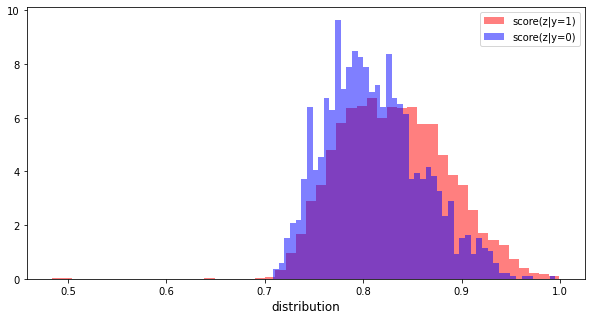

In [15]:
fig , ax = plt.subplots(1,1, figsize = (10,5))
uno_distr = prob_a[y_train==1]
zero_distr = prob_a[y_train==0]
ax.hist(uno_distr, color="red", label = "score(z|y=1)", density=True, alpha=0.5, bins=50)
ax.hist(zero_distr, color="blue", label = "score(z|y=0)", density=True, alpha=0.5, bins=50)
ax.set_xlabel("score", fontsize=12)
ax.set_xlabel("distribution", fontsize=12)
plt.legend()
plt.show()

....not a very good model!!!

Confusion matrix for threshold = 0.05


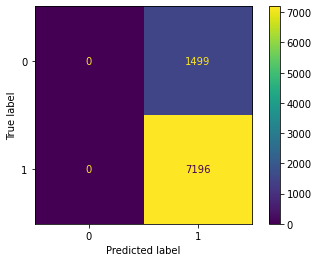

Confusion matrix for threshold = 0.1


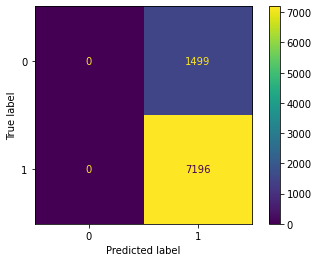

Confusion matrix for threshold = 0.15000000000000002


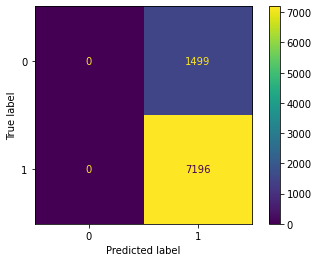

Confusion matrix for threshold = 0.2


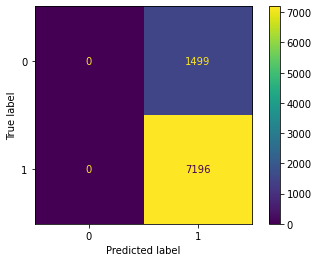

Confusion matrix for threshold = 0.25


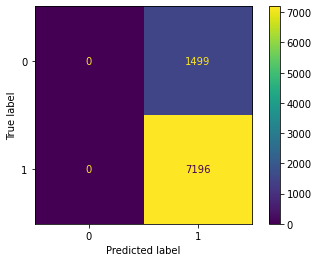

Confusion matrix for threshold = 0.3


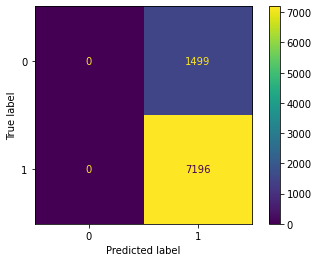

Confusion matrix for threshold = 0.35000000000000003


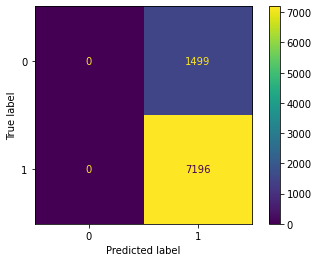

Confusion matrix for threshold = 0.4


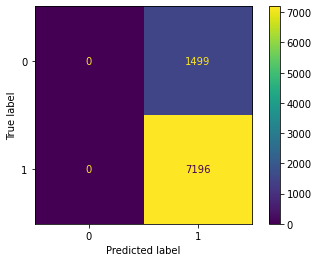

Confusion matrix for threshold = 0.45


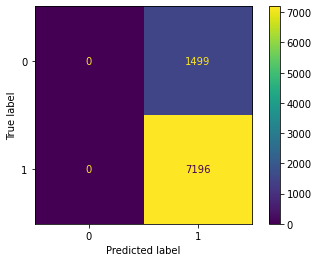

Confusion matrix for threshold = 0.5


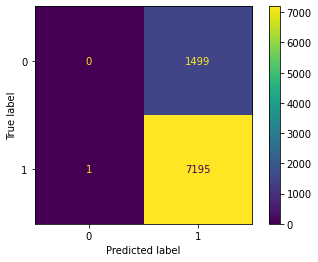

Confusion matrix for threshold = 0.55


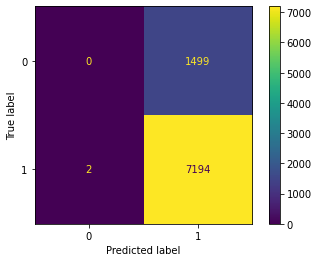

Confusion matrix for threshold = 0.6000000000000001


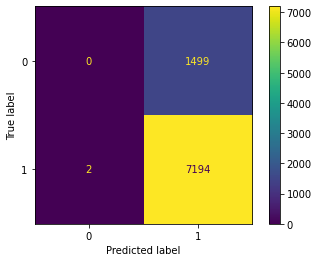

Confusion matrix for threshold = 0.6500000000000001


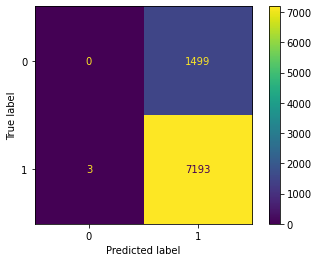

Confusion matrix for threshold = 0.7000000000000001


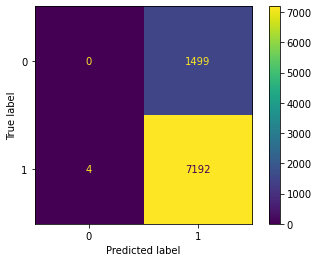

Confusion matrix for threshold = 0.7500000000000001


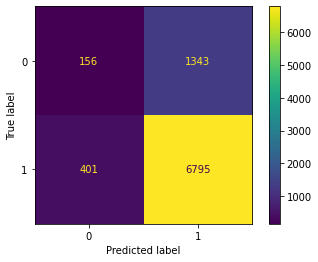

Confusion matrix for threshold = 0.8


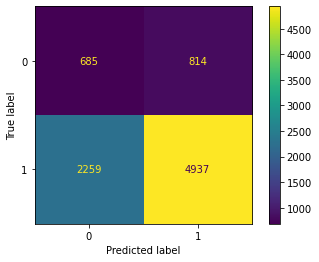

Confusion matrix for threshold = 0.8500000000000001


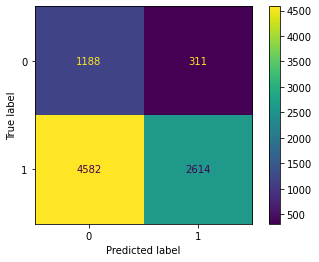

Confusion matrix for threshold = 0.9000000000000001


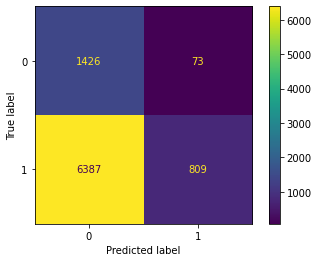

Confusion matrix for threshold = 0.9500000000000001


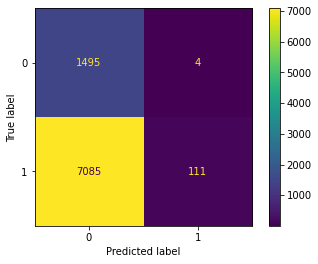

ALL METRICS


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
THRESHOLD,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
accuracy,0.827602,0.827602,0.827602,0.827602,0.827602,0.827602,0.827602,0.827602,0.827602,0.827487,0.827372,0.827372,0.827257,0.827142,0.799425,0.646578,0.437263,0.257044,0.184704
recall,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999861,0.999722,0.999722,0.999583,0.999444,0.944275,0.686076,0.363257,0.112424,0.015425
tnr,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999861,0.999722,0.999722,0.999583,0.999444,0.944275,0.686076,0.363257,0.112424,0.015425
fpr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000139,0.000278,0.000278,0.000417,0.000556,0.055725,0.313924,0.636743,0.887576,0.984575
precision,0.827602,0.827602,0.827602,0.827602,0.827602,0.827602,0.827602,0.827602,0.827602,0.827582,0.827562,0.827562,0.827543,0.827523,0.834972,0.858459,0.893675,0.917234,0.965217
f1_score,0.90567,0.90567,0.90567,0.90567,0.90567,0.90567,0.90567,0.90567,0.90567,0.905601,0.905532,0.905532,0.905463,0.905394,0.886266,0.762648,0.51655,0.200297,0.030365


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
THRESHOLD = np.arange(0.05,1,0.05)
# df to store results
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "recall", "tnr", "fpr", "precision", "f1_score"]) 
# threshold column
results['THRESHOLD'] = THRESHOLD                                                                           
# fit data to model
      
j = 0                                                                                                      
# iterate over each threshold    
for i in THRESHOLD:     
    # if prob > threshold, predict 1
    preds = np.where(prob_a > i, 1, 0)                                       
    # confusion matrix (in percentage)
    print('Confusion matrix for threshold =',i)
    cm = confusion_matrix(y_train, preds, labels=lgstc_reg.classes_) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgstc_reg.classes_)
    disp.plot()
    plt.show()
    TP = cm[0][0]   # True Positives
    FN = cm[0][1]   # False Positives
    FP = cm[1][0]   # True Negatives
    TN = cm[1][1]   # False Negatives
        
    results.iloc[j,1] = accuracy_score(y_train, preds) 
    results.iloc[j,2] = recall_score(y_train, preds)
    results.iloc[j,3] = TN/(FP+TN)  # True negative rate
    results.iloc[j,4] = FP/(FP+TN)  # False positive rate
    results.iloc[j,5] = precision_score(y_train, preds)
    results.iloc[j,6] = f1_score(y_train, preds)
   
    j += 1

print('ALL METRICS')
results.T
   

<br>
We note here from the confusion matrix at threshold 0.75 that while the model is good at identifying good loans, however it isn't good at identifying the bad loans at all.

We also note that increasing the threshold results in decrease in overall accuracy. But the percentage of default loans identified as default is higher with increasing threshold. We know by now that maximizing the accuracy does not necessarily create the best model. Thus, lets look at some other metrics.

<IPython.core.display.Javascript object>


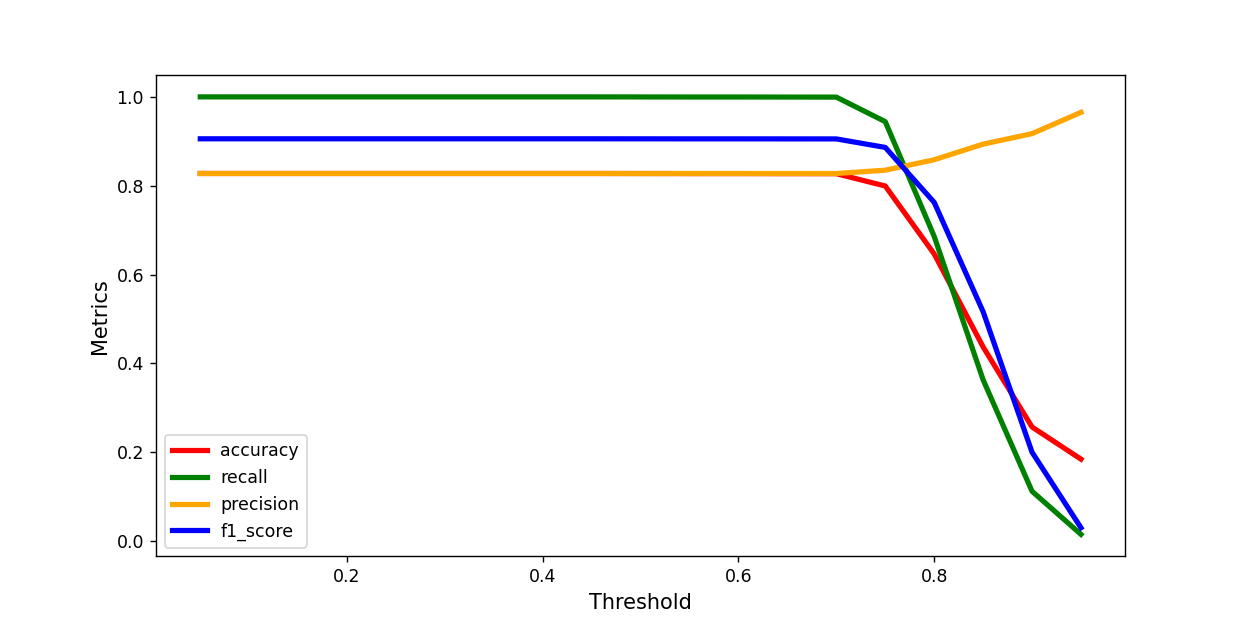

In [17]:
%matplotlib notebook

fig, ax = plt.subplots(1,1,figsize=(10,5))
thr = results["THRESHOLD"].values
acc = results["accuracy"].values
recall = results["recall"].values
precision = results["precision"].values
f1_score = results["f1_score"].values
ax.plot(thr,acc, c="red", label="accuracy" ,  linewidth=3)
ax.plot(thr,recall, c="green", label="recall" ,  linewidth=3)
ax.plot(thr,precision, c="orange", label="precision",  linewidth=3 )
ax.plot(thr,f1_score, c="blue", label="f1_score" ,  linewidth=3)
ax.legend()
ax.set_xlabel("Threshold", fontsize=12)
ax.set_ylabel("Metrics", fontsize=12)
plt.show()

This graph is very usefull to choice a threshold!

### What is the AUC - ROC Curve?
AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease. The ROC curve is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.

![caption](./pic/chapter-4-1_pic_8.png)

In the context of classification tasks, some sklearn estimators also implement the predict_proba method that returns the class probabilities for each data point. The method accepts a single argument that corresponds to the data over which the probabilities will be computed and returns an array of lists containing the class probabilities for the input data points.

In [26]:
lr_prob=lgstc_reg.predict_proba(X_train)
lr_prob=lr_prob[:, 1]

<IPython.core.display.Javascript object>


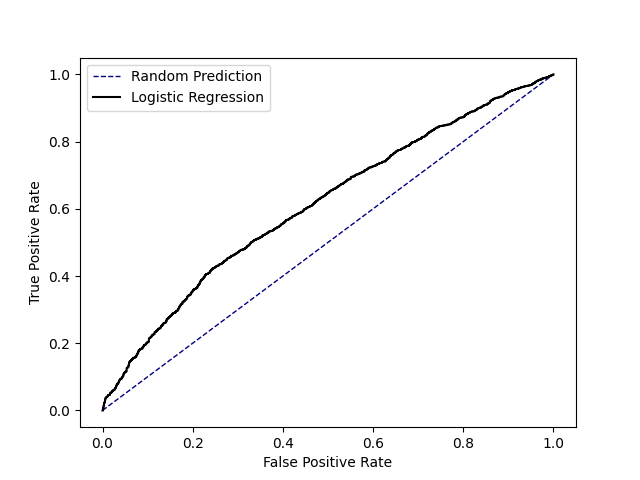

AUC Score :  0.6108687522272583
Not a good score


In [29]:
%matplotlib notebook
lr_auc=roc_auc_score(y_train, lr_prob)

lr_fpr,lr_tpr, thresholds =roc_curve(y_train,lr_prob)

plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label='Random Prediction')
plt.plot(lr_fpr,lr_tpr , color="black" , label='Logistic Regression')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("AUC Score : ", lr_auc)
print("Not a good score")

<IPython.core.display.Javascript object>


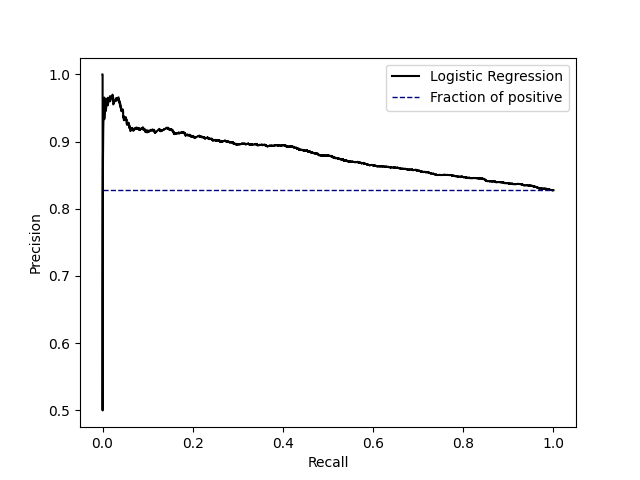

In [33]:
%matplotlib notebook
from sklearn.metrics import precision_recall_curve
precision , recall , thresholds = precision_recall_curve(y_train,lr_prob)

plt.plot(recall, precision , color="black" , label='Logistic Regression')
plt.plot([0,1], [0.82760207, 0.82760207],  color="navy", lw=1, linestyle="--", label='Fraction of positive')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


## References

John C. Hull, **Machine Learning in Business: An Introduction to the World of Data Science**, Amazon, 2019.

Paul Wilmott, **Machine Learning: An Applied Mathematics Introduction**, Panda Ohana Publishing, 2019.